# [Classifying Twitter Sentiments through Supervise Learning ](https://www.kaggle.com/kazanova/sentiment140)

**Introduction**

Twitter is one of the most popular microblogging and social networking platforms for people around the world. This platform lets people communicate and interact via posts (aka "tweets"). Tweets are casual forms of texts and are limited to 140 characters.

Tweets are used by different parties for varied reasons. For instance, consumers use Twitter to research products before purchasing them. Twitter information are used to analyze the customer reviews and sentiments to make a better purchasing distance. Henceforth, sentiment analysis plays a vital part in our everyday life.

For this project, I will use Twitter data to identify the positive and negative sentiments in making a purchasing decision. This will help us identify the patterns on how consumers make their purchasing decisions through sentiments on Twitter.

**Problem Statement:**

The objective of this task is to detect positive sentiments in our dataset. For instance, tweets with a positive sentiment may mean that the customer is satisfied about the product. This information can be used to predict customer spending patterns for the company's future products. It would inherently help us determine revenue for our products. Therefore, my task in this project, is to classify the good(positive) tweets from the bad(negative) ones. 

To start off the following assumptions have already been made during the initial phase of our data collection 
- Ignore neutral tweets 
- The parameters in our tweets are in English
- Ignore emoticons to make the classification processess much simpler

In addition to these assumptions, let us use the following binary terms to classify the our tweets. I believe that this would make our process more simplified:
- **1** indicates a positive tweet
- **0** indicates a negative tweet


In [1]:
# Importing Packages
%matplotlib inline
import sys, os, random
import nltk, re
import time
import tweepy 
import scipy
import string
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy as tw
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

# preprocessing and feature extraction
# bag of words scipy.sparse()
from scipy.stats.mstats import winsorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Training the classifier
from sklearn.pipeline import Pipeline # classifier to make the vectorizer => transformer => classifier easier 
from sklearn.model_selection import train_test_split

# Classifiers for building models
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Evaluation 
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

**Approach**

I will be taking the following steps in analyzing the sentiments in our dataset:

1. Read the Twitter dataset 
2. Initial Exploration
3. Preprocessing and Data Cleaning 
4. Exploratory Analysis and Visualization
4. Feature Extraction 
5. Creating models 
6. Evaluating models

Let's dive into the insights of our dataset:

## I. Reading the Twitter Dataset

In [2]:
file_name = "/home/kaneeshadawood/train.csv"

# Loading data from the csv file. 
data = pd.read_csv("/home/kaneeshadawood/train.csv", encoding='latin-1', header=None)
  
# Renaming columns
data.columns = ["sentiment", "user_id", "date", "query", "user", "tweet"] 
data.head(10)

,sentiment,user_id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


**Content**

I named the following columns to get a better understanding of our data fields:

- sentiment: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- user_id: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- query: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- tweet: the text of the tweet (Lyx is cool)

In [3]:
# contents of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment    1600000 non-null int64
user_id      1600000 non-null int64
date         1600000 non-null object
query        1600000 non-null object
user         1600000 non-null object
tweet        1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


The dataset contains 1600000 observations and 6 fields in total. Sentiment and ID are the only numeric fields, whereas the rest are classified into categorical variables.

## II. Initial Data Exploration

Let's now find out the number of positive, negative, and neutral tweets in our data set. For this purpose, I will use pandas `.value_counts()` method.

In [4]:
count = data['sentiment'].value_counts()
count

4    800000
0    800000
Name: sentiment, dtype: int64

Even though our data set informed us that there is a neutral class (labelled '2'), our exploration indicates that there aren't any neutral tweets. In other words, tweets are split on a 50/50 range, where the raw data have been labelled as negative('0') and postive('4') respectively.

Let's visualize our balanced dataset through a countplot.

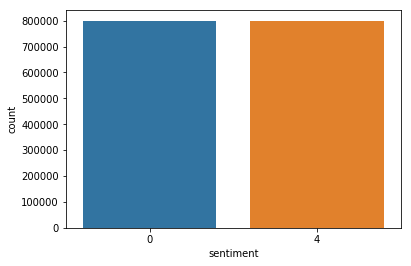

In [5]:
sns.countplot(x='sentiment', data=data)

The data does not indicate any missing values, but let's confirm the following:

In [6]:
total_null = data.isnull().sum().sort_values(ascending=False)
total_null

tweet        0
user         0
query        0
date         0
user_id      0
sentiment    0
dtype: int64

In [7]:
# Finding the unique values in our observations.
data.nunique()

sentiment          2
user_id      1598315
date          774363
query              1
user          659775
tweet        1581466
dtype: int64

There are multiple tweets from a wide range of user_ids. User Id's are the unique ID given to each Twitter user. Our dataset shows more user ids than the amount of unique Twitter users. 

Moreover, it is evident that there is only one query in the 'query' column which is 'No_QUERY'. Let's eliminate this column since it adds to no value to our data.

I chose to sample our data to get a clearer insight on our tweet sentiments. 

In [8]:
# Sampling the subset of our tweet
positive_tweet = data[data.sentiment==4].iloc[:200000,:]
print(positive_tweet.shape)
negative_tweet = data[data.sentiment==0].iloc[:200000,:]
print(negative_tweet.shape)

(200000, 6)
(200000, 6)


In [9]:
data = pd.concat([positive_tweet,negative_tweet],axis = 0)
print(data.shape)
data.head()

(400000, 6)


,sentiment,user_id,date,query,user,tweet
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [10]:
# creating a field that indicates the length of our text characters
data['len'] = [len(t) for t in data.tweet]
data.head()

,sentiment,user_id,date,query,user,tweet,len
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,44
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,72
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",137
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,104
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,47


Let's now discover the length of the tweet using a boxplot.

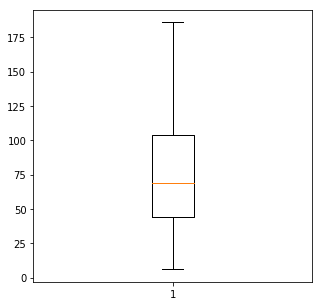

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data['len'])
plt.show()

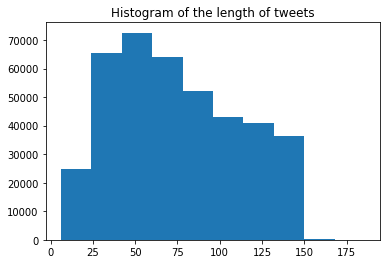

In [12]:
plt.hist(data["len"])
plt.title("Histogram of the length of tweets")
plt.show()

In [13]:
data['len'].mean()

74.216735

The length of the tweets is skewed to the right with an average of 74 characters. 

Let's now detect the outliers despite our distribution. I chose to use the Interquartile Range(IQR) method to detect outliers since not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. The IQR is calculated by taking into account the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

In [14]:
# Calculating the IQR using NumPy's percentile() method 
q75, q25 = np.percentile(data["len"], [75 ,25])
iqr = q75 - q25

# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
outliers = [x for x in data['len'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Identified outliers: 0


Outliers are extreme values that are outside the range of what is expected and unlike the other data. We do not have any outliers in our sample set of data; therefore, we could focus on our new step of cleaning the data.

## III. Data Preprocessing and Cleaning

The raw Twitter text include people's casual opinions in the form of informal language. The tweets above include, punctuations, special characters, user mentions etc. We have also identified outliers in our dataset. These features add noise to our data and should be eliminated before we create our model.

Let's now dive into performing the following preprocessing steps prior to building our model. I chose to use the following steps to get rid of the noise in our dataset:

- Rename the Postive sentiment as '1'
- Drop columns: 'user_id', 'date', 'query'
- Convert tweets to lower case
- Preprocess the 'tweet' field
    - Remove punctuations, numbers, irrelevant characters
    - Remove Twitter handles, URLs 
    - Eliminate White spaces
- Tokenization and normalization
- Remove stopwords
- Lemmatization: Transform words to dictionary base form

**1. Renaming the Positive Sentiment Polarity**

In [15]:
# Casting the positive sentiment to 1
data[data.loc[:, 'sentiment'] == 4] = 1

# Confirming the above code:
print(data['sentiment'].value_counts())

1    200000
0    200000
Name: sentiment, dtype: int64


**2. Dropping columns**

In [16]:
data.drop(['user_id','date','query','user'], axis=1, inplace=True)

I chose to drop the above columns so that we could focus more specifically on classifying our text Twitter data along with our sentiments. Moreover, the field 'query' indicates 'no_query' at all instances which means that this feature in a constant. 

**3. Converting tweets to lower case**

In [18]:
# Converting Tweets to lower case
data['clean_tweet'] = data['tweet'].apply(lambda x: str(x).lower())

**4. Cleaning tweet field**

In [19]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
# Eliminating Puntuations:
def remove_punct(tweet):
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', '', tweet)
    return tweet

data['clean_tweet'] = data['clean_tweet'].apply(lambda x: remove_punct(x))

In [21]:
# Removing Twitter Handles:
data['clean_tweet'] = data['clean_tweet'].str.replace("@[\w]*", " ") 

# Removing URLs
data['clean_tweet'] = data['clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")

# Removing numbers, special characters
data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ") 

# Removing numbers
data['clean_tweet'] = data['clean_tweet'].str.replace('\d+', '')

# Removing whitespaces
data['clean_tweet'] = data['clean_tweet'].str.strip()

# Removing Single characters
data['clean_tweet'] = data['clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")

**5. Tokenization and Normalization**

In [22]:
data['clean_tweet'] = data['clean_tweet'].str.split()

**6. Dealing with Stop Words**

In [23]:
# Removing Stopwords
nltk.download('stopwords')

# Here is a list of the stopwords identified by NLTK.

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaneeshadawood/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Removing stop words

from nltk.corpus import stopwords
stop = stopwords.words("english")                

data['clean_tweet'] = data['clean_tweet'].apply(lambda x: [word for word in x if word not in stop])

In [25]:
# Expanding the tweet
def expand_tweet(tweet):
        expanded_tweet = []
        for word in tweet:
            if re.search("n't", word):
                expanded_tweet.append(word.split("n't")[0])
                expanded_tweet.append("not")
            else:
                expanded_tweet.append(word)
        return expanded_tweet

data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: expand_tweet(tweet))

**6. Lemmatization**

In [26]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/kaneeshadawood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer

lemma = nltk.WordNetLemmatizer()

data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: [lemma.lemmatize(word) for word in tweet])

**7. Stemming**

In [28]:
from nltk.stem import PorterStemmer

porterStemmer = PorterStemmer()

data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])

In [29]:
# combining words to tweets 
data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: ' '.join(tweet)) 

Let's save our clean data to a csv file.

In [30]:
df = pd.DataFrame(data)

df.to_csv('clean_data.csv', index=False)

## IV. Exploratory Analysis

Now that we our data is preprocessed, let's explore the text one more time to identify the most important features. This will help us understand the most important features we need to build our model.

In [30]:
positive_tweets = ' '.join(data[data['sentiment'] == 1]['clean_tweet'].str.lower())
negative_tweets = ' '.join(data[data['sentiment'] == 0]['clean_tweet'].str.lower())

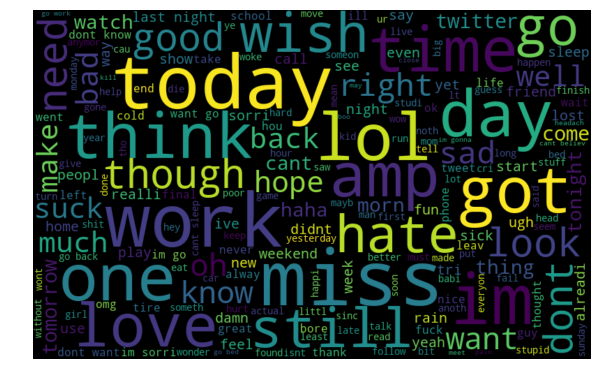

In [31]:
# Visualizing our processed data:
# Generate a word cloud image
all_words = ' '.join([text for text in data['clean_tweet']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

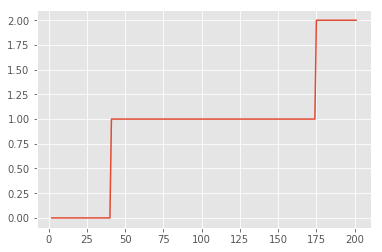

In [32]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

style.use("ggplot")

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    pullData = open("clean_data.csv","r").read()
    lines = pullData.split('\n')

    xar = []
    yar = []

    x = 1
    y = 0

    for l in lines[-200:]:
        x += 1
        if "pos" in l:
            y += 1
        elif "neg" in l:
            y -= 0

        xar.append(x)
        yar.append(y)
        
    ax1.clear()
    ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()

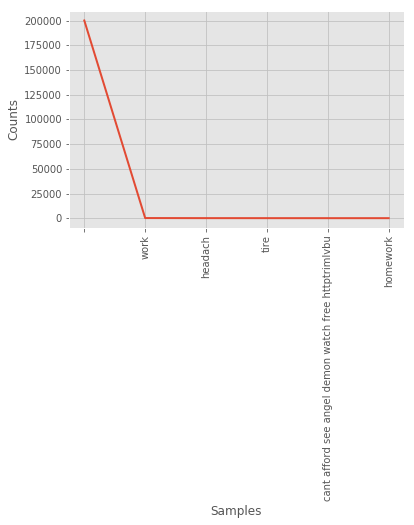

In [33]:
# Frequency Distribution Plot
from nltk.probability import FreqDist

fdist = FreqDist(data['clean_tweet'])

fdist.plot(6,cumulative=False)
plt.show()

No handles with labels found to put in legend.


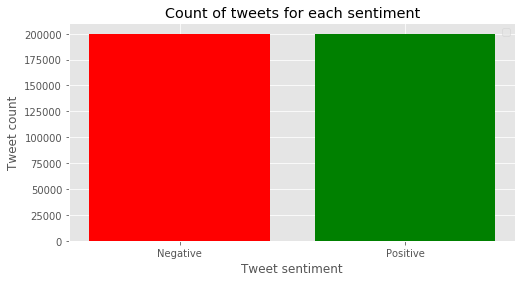

In [34]:
sentiment_count = data['sentiment'].value_counts() # Returned in descending order [1, 0]
plt.figure(figsize = (8, 4))
plt.xticks([1, 0], ['Positive', 'Negative'])
plt.xticks([1, 0])
plt.bar(x = sentiment_count.keys(), 
        height = sentiment_count.values, 
        color = ['g', 'r'])
plt.xlabel("Tweet sentiment")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each sentiment")
plt.legend()

**Splitting the data into train and test set**

To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

Let's split dataset by using function train_test_split(). You need to pass basically 3 parameters features, target, and test_set size. Additionally, you can use random_state to select records randomly.

In [35]:
# Train test split
print("Splitting train and test dataset into 80:20") 
X_train, X_test, y_train, y_test = train_test_split(data['clean_tweet'], data['sentiment'], test_size = 0.20, random_state = 100)
train_dataset = pd.DataFrame({
    'clean_tweet': X_train,
    'sentiment': y_train
    })
print("Train data distribution:")
print(train_dataset['sentiment'].value_counts())
test_dataset = pd.DataFrame({
    'clean_tweet': X_test,
    'sentiment': y_test
    })
print("Test data distribution:")
print(test_dataset['sentiment'].value_counts())
print("Split complete") 

Splitting train and test dataset into 80:20
Train data distribution:
1    160076
0    159924
Name: sentiment, dtype: int64
Test data distribution:
0    40076
1    39924
Name: sentiment, dtype: int64
Split complete


In [36]:
# Save train data
print("Saving train data")

train_data = train_dataset.to_csv('train.csv', index = False)
print("Train data saved to data/train.csv")

# Save test data
print("Saving test data")
test_data = test_dataset.to_csv('test.csv', index = False)
print("Test data saved to data/test.csv")

Saving train data
Train data saved to data/train.csv
Saving test data
Test data saved to data/test.csv


## IV. Feature Extraction

In order to extract features I will use the following methods:
- Bag of Words 
- TF-IDF Feature 

I believe that these methods would help us identify the most unique features to build our models.

**TF-IDF Features**

TF-IDF(Term Frequency-Inverse Document Frequency) is a numerical statistic that is intended to reflect the importance of a word in a document from a collection or corpus. As the name implies, this model helps us identify the frequency of the words.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Applying TF-IDF transformation")
tfidfVectorizer = TfidfVectorizer(min_df = 5, max_features = 1000)
tfidfVectorizer.fit(train_dataset['clean_tweet'].apply(lambda x: np.str_(x)))
train_tweet_vector = tfidfVectorizer.transform(train_dataset['clean_tweet'].apply(lambda x: np.str_(x)))
test_tweet_vector = tfidfVectorizer.transform(test_dataset['clean_tweet'].apply(lambda x: np.str_(x)))

Applying TF-IDF transformation


**Bag of Words**

Bag-of-Words is a method that extracts text and represent it into numerical features. The words are converted to the binary form to help us build our intended model. In the bag of words method, the model is only considered about whether known words occur in the dataset and not about where in the dataset. 

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

print("Applying Bag of Words transformation")
count_vectorizer = CountVectorizer(min_df = 5, max_features = 1000, stop_words='english') 
count_vectorizer.fit(train_dataset['clean_tweet'].apply(lambda x: np.str_(x)))
train_tweet_vector = count_vectorizer.transform(train_dataset['clean_tweet'].apply(lambda x: np.str_(x)))
test_tweet_vector = count_vectorizer.transform(test_dataset['clean_tweet'].apply(lambda x: np.str_(x)))
train_tweet_vector = count_vectorizer.transform(train_dataset['clean_tweet'].apply(lambda x: np.str_(x)))
test_tweet_vector = count_vectorizer.transform(test_dataset['clean_tweet'].apply(lambda x: np.str_(x))) 

Applying Bag of Words transformation


## V. Modelling

Now that we have extracted our features we can build our models using the two feature sets.

### 1. Building models with TF-IDF features

**Random Forest Model**

In [39]:
# Training
print("Training Random Forest Classifier")
randomForestClassifier = RandomForestClassifier()
randomForestClassifier.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = randomForestClassifier.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data")
prediction = randomForestClassifier.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Training Random Forest Classifier
Predicting on train data
Training accuracy: 98.9746875%
Predicting on test data
Testing accuracy: 98.98875000000001%


**OLS Regression Model**

We will use logistic regression to build the models. It predicts the probability of occurrence of an event by fitting data to a logit function.

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression()
lr.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = lr.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data") 
prediction = lr.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Predicting on train data
Training accuracy: 98.7725%
Predicting on test data
Testing accuracy: 98.7475%


**Naive Bayes Model**

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Model Generation Using Multinomial Naive Bayes
MultinomialNB = MultinomialNB()
MultinomialNB.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = MultinomialNB.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data") 
prediction = MultinomialNB.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Predicting on train data
Training accuracy: 90.343125%
Predicting on test data
Testing accuracy: 90.36375%


**Gradient Boosting**

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

# Model Generation Using Gradient Boosting
GradientBoosting = GradientBoostingClassifier()
GradientBoosting.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = GradientBoosting.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data") 
prediction = GradientBoosting.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Predicting on train data
Training accuracy: 86.62218750000001%
Predicting on test data
Testing accuracy: 86.59125%


### 2. Building models with Bag of Words features

**Random Forest Model**

In [43]:
# Training
print("Training Random Forest Classifier")
randomForestClassifier = RandomForestClassifier()
randomForestClassifier.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = randomForestClassifier.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data")
prediction = randomForestClassifier.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Training Random Forest Classifier
Predicting on train data
Training accuracy: 98.6415625%
Predicting on test data
Testing accuracy: 98.62875%


**OLS Regression Model**

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression()
lr.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = lr.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data") 
prediction = lr.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Predicting on train data
Training accuracy: 98.2459375%
Predicting on test data
Testing accuracy: 98.16125%


**Naive Bayes**

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Model Generation Using Multinomial Naive Bayes
MultinomialNB = MultinomialNB()
MultinomialNB.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = MultinomialNB.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data") 
prediction = MultinomialNB.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Predicting on train data
Training accuracy: 90.798125%
Predicting on test data
Testing accuracy: 90.77374999999999%


**Gradient Boosting**

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

# Model Generation Using Gradient Boosting
GradientBoosting = GradientBoostingClassifier()
GradientBoosting.fit(train_tweet_vector, train_dataset['sentiment'])

# Prediction
print("Predicting on train data")
prediction = GradientBoosting.predict(train_tweet_vector)
print("Training accuracy: {}%".format(accuracy_score(train_dataset['sentiment'], prediction)*100))

print("Predicting on test data") 
prediction = GradientBoosting.predict(test_tweet_vector)
print("Testing accuracy: {}%".format(accuracy_score(test_dataset['sentiment'], prediction)*100))

Predicting on train data
Training accuracy: 86.3096875%
Predicting on test data
Testing accuracy: 86.24125000000001%


## VI. Evaluation

I built models using two feature extraction techniques (TF-IDF and Bag-of-words) to analyze their predictability in both training and testing sets. I chose Random Forest, Logistic Regression, Naive Bayes, and Gradient Boosting to help us determine the most appropriate model for our Twitter sentiments. 

Our feature extractions provide similar accuracy scores for all models. Random Forest model performs well in both instances with a 98.74% training score and 98.99% for the testing accuracy score. In comparison, Logistic Regression model has a similar accuracy score in both training and test datasets. Gradient Boosting model gives us a lower accuracy score in both instances (training: 86.62%, testing: 86.59%)

## VII. Future Work

- I plan on using more advanced NLP techniques to classify our Twitter data. 
- I chose a sample of 200000 for both positive and negative tweets. I intend on increasing the sample size and analyzing the impact of their results on our models in future. 

## Resources:

- [The dataset](https://www.kaggle.com/kazanova/sentiment140)
- [Scikit-learn machine learning libararies](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- [Natural Language Toolkit](https://www.nltk.org/)